In [112]:
import warnings
warnings.filterwarnings("ignore") 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from tqdm import tqdm

import pickle
import os
import re

import bz2
import _pickle as cPickle

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras.initializers import Constant

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [44]:
TWEMOJI_DATASET = './datasets/samples/combined_csv.csv'
EMOJI_MAPPINGS = './datasets/emoji_map_1791.csv'
pkl_dest = os.path.join('src', 'pkl_objects')

In [45]:
twemoji = pd.read_csv(TWEMOJI_DATASET)

In [46]:
mappings = pd.read_csv(EMOJI_MAPPINGS)

In [47]:
twemoji = twemoji.reindex(np.random.permutation(twemoji.index))

# Mappings

In [48]:
# we can see that we now have the dataframe that contain all 
# the emoji mappings
mappings.head(5) 

,Unnamed: 0,category,title,shorts,unicode_alternates,keywords,ucode_short,ucode,aliases,alt_title,aliases_ascii
0,#️⃣,symbols,keycap number sign,[hash],0023-fe0f-20e3,"[keycap, symbol, pound, hash, number]",0023_fe0f_20e3,#️⃣,NaN,NaN,NaN
1,*️⃣,symbols,keycap asterisk,[asterisk],002a-fe0f-20e3,"[keycap, symbol, asterisk, star]",002a_fe0f_20e3,*️⃣,[:keycap_asterisk:],NaN,NaN
2,0️⃣,symbols,keycap digit zero,[zero],0030-fe0f-20e3,"[, keycap, symbol, number, zero, math]",0030_fe0f_20e3,0️⃣,NaN,NaN,NaN
3,1️⃣,symbols,keycap digit one,[one],0031-fe0f-20e3,"[, keycap, symbol, number, one, math]",0031_fe0f_20e3,1️⃣,NaN,NaN,NaN
4,2️⃣,symbols,keycap digit two,[two],0032-fe0f-20e3,"[, keycap, symbol, two, number, math]",0032_fe0f_20e3,2️⃣,NaN,NaN,NaN


# Cleaning and Preparing

In [49]:
replace_puncts = {'`': "'", '′': "'", '“':'"', '”': '"', '‘': "'"}

strip_chars = [',', '.', '"', ':', ')', '(', '-', '|', ';', "'", '[', ']', '>', '=', '+', '\\', '•',  '~', '@', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

puncts = ['!', '?', '$', '&', '/', '%', '#', '*','£']

In [50]:
def clean_str(x):
    x = str(x)
    
    x = x.lower()
    
    x = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "url", x)
    
    for k, v in replace_puncts.items():
        x = x.replace(k, f' {v} ')
        
    for punct in strip_chars:
        x = x.replace(punct, ' ')
        
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
        
    x = x.replace(" '", " ")
    x = x.replace("' ", " ")
    
    return x

In [51]:
# lets see how many columns 
# does the dataset have
twemoji.columns

Index(['id', 'annotations', 'id_text'], dtype='object')

In [52]:
# rename annotations to target
# rename id_text to tweet
twemoji = twemoji.rename(columns={"annotations":'target', "id_text":"text"})

In [53]:
twemoji.head() 

,id,target,text
2358381,746807711090810880,1620,NaN
1334601,742626238104272896,186,NaN
3430516,742075272665665536,1399,NaN
2979477,747562766152544256,1620,NaN
733893,746702913435738112,1392,NaN


In [54]:
# since the id column is no longer needed
# we can simply drop it
twemoji = twemoji.drop(columns=["id"])

In [55]:
twemoji.head()

,target,text
2358381,1620,NaN
1334601,186,NaN
3430516,1399,NaN
2979477,1620,NaN
733893,1392,NaN


In [56]:
# Lets check how many null values exist in 
# the dataset
twemoji['text'].isna().sum()

3878060

In [57]:
# We can't do much with null values
# So we drop them
twemoji = twemoji.dropna()

In [58]:
twemoji['text'] = twemoji['text'].apply(clean_str)

In [59]:
twemoji.head()

,target,text
1397592,1381,oh ? nice nice
1811660,1447,i ve not seen the dm oh
1766770,1422,x06 on air just leave me alone
1656931,1387,just beat canyon state by
1779328,1381,and we all hate them trucks on the road


In [60]:
# Lets check how big is the data set now
twemoji.shape

(88567, 2)

# Exploration

<AxesSubplot:xlabel='target'>

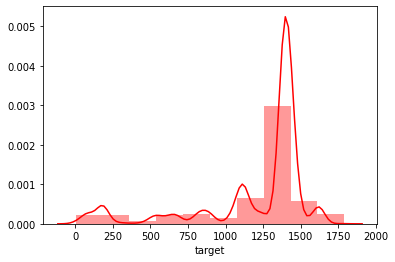

In [61]:
# lets see the distribution of our target values
sns.distplot(twemoji['target'], color='red', bins=10)

In [62]:
most_frequent = twemoji['target'].value_counts().idxmax() 
most_frequent

1381

In [63]:
# The laughing face emoji is the most popular in this dataset
mappings.loc[most_frequent]

Unnamed: 0                                                            😂
category                                                         people
title                                            face with tears of joy
shorts                                                            [joy]
unicode_alternates                                                  NaN
keywords              [emotion, cry, tear, joy, smiley, sarcastic, f...
ucode_short                                                       1f602
ucode                                                                 😂
aliases                                                             NaN
alt_title                                                           NaN
aliases_ascii                                               [:'), :'-)]
Name: 1381, dtype: object

In [64]:
# Lets see the 10 most frequently used emojis
top_twenty = twemoji['target'].value_counts()[:20].index.tolist() 
top_twenty

[1381,
 1447,
 1424,
 1392,
 1389,
 186,
 1620,
 1420,
 1446,
 1403,
 1138,
 1397,
 1384,
 1107,
 830,
 1056,
 1393,
 1380,
 1394,
 1210]

In [65]:
# lets see the mappings
mappings.loc[top_twenty].head()

,Unnamed: 0,category,title,shorts,unicode_alternates,keywords,ucode_short,ucode,aliases,alt_title,aliases_ascii
1381,😂,people,face with tears of joy,[joy],NaN,"[emotion, cry, tear, joy, smiley, sarcastic, f...",1f602,😂,NaN,NaN,"[:'), :'-)]"
1447,🙄,people,face with rolling eyes,"[rolling_eyes, face_with_rolling_eyes]",NaN,"[emotion, eyes, rolling eyes, smiley, sarcasti...",1f644,🙄,[:face_with_rolling_eyes:],NaN,NaN
1424,😭,people,loudly crying face,[sob],NaN,"[emotion, sob, tear, cry, smiley, sad, heartbr...",1f62d,😭,NaN,NaN,NaN
1392,😍,people,smiling face with heart shaped eyes,[heart_eyes],NaN,"[emotion, heart, eye, love, smiley, face, beau...",1f60d,😍,NaN,smiling face with heart-shaped eyes,NaN
1389,😊,people,smiling face with smiling eyes,[blush],NaN,"[emotion, beautiful, good, eye, smiley, face, ...",1f60a,😊,NaN,NaN,NaN


In [66]:
# We see that there is a high density around 1000-1500
# lets reduce the number of emojis there exists to the
# top 10 emojis that exists in the dataset
# we could reduce the complexity of our problem. 
index_names = twemoji[~twemoji['target'].isin(top_twenty)].index
twemoji = twemoji.drop(index_names)

<AxesSubplot:xlabel='target'>

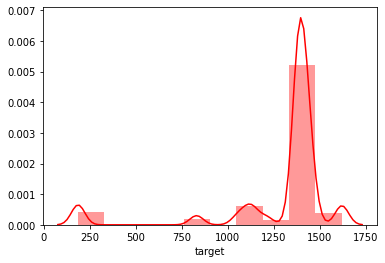

In [67]:
# lets see the distribution once again
sns.distplot(twemoji['target'], color='red', bins=10)

In [68]:
# For sanity check lets see if the remaining emojis
# are only the top ten emojis
twemoji['target'].value_counts().index.tolist() 

[1381,
 1447,
 1424,
 1392,
 1389,
 186,
 1620,
 1420,
 1446,
 1403,
 1138,
 1397,
 1384,
 1107,
 830,
 1056,
 1393,
 1380,
 1394,
 1210]

In [69]:
twemoji.shape

(44933, 2)

<AxesSubplot:xlabel='target', ylabel='count'>

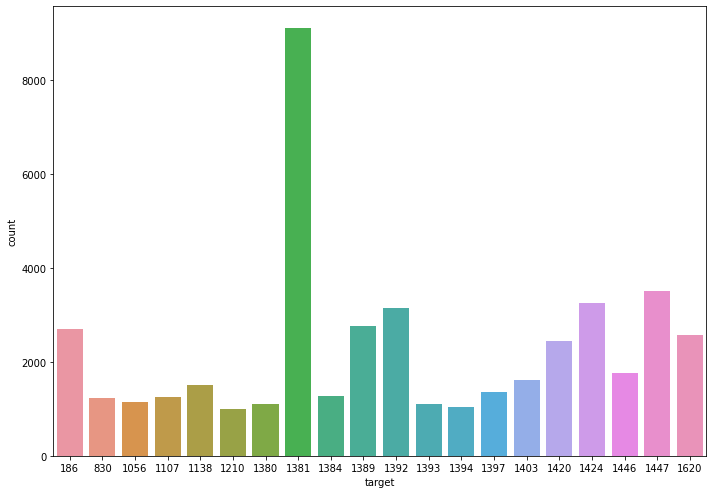

In [70]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.countplot(ax=ax, x='target', data=twemoji)

## Imbalance Dataset 

In [71]:
MINIMUM_CLASS_SIZE = min(np.array(twemoji['target'].value_counts()))

In [72]:
twemoji = twemoji.groupby('target').apply(lambda x: x.sample(MINIMUM_CLASS_SIZE))

In [73]:
twemoji.shape

(20080, 2)

<AxesSubplot:xlabel='target', ylabel='count'>

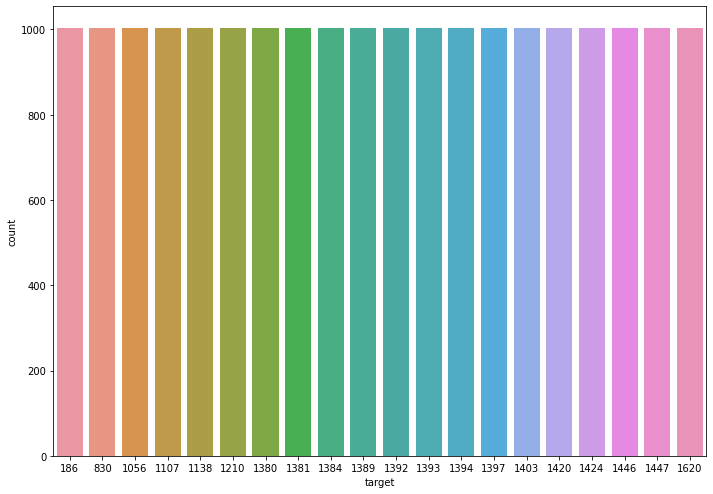

In [74]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.countplot(ax=ax, x='target', data=twemoji,)

In [75]:
twemoji['l'] = twemoji['text'].apply(lambda x: len(str(x).split(' '))) 

In [76]:
print("mean length of sentence: " + str(twemoji.l.mean()))
print("max length of sentence: " + str(twemoji.l.max()))
print("std dev length of sentence: " + str(twemoji.l.std()))

mean length of sentence: 10.139641434262948
max length of sentence: 60
std dev length of sentence: 7.126312103070171


In [77]:
sequence_length = 60

## Tokenize

In [78]:
max_features = 2000 # numer of words we care about

tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>', filters=' ')
tokenizer.fit_on_texts(twemoji['text'].values)

In [79]:
# convert all text to vectors
X = tokenizer.texts_to_sequences(twemoji['text'].values) 

In [80]:
# pad sequences so they are all the same length
X = pad_sequences(X, sequence_length)

In [81]:
y = pd.get_dummies(twemoji['target']).values

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [83]:
print('Test Set Size ' + str(len(X_test)))

Test Set Size 2008


## GloVe

In [84]:
embeddings_index = {}
f = open(os.path.join('src/embeddings', 'glove.twitter.27B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close

print('Found %s word vectors' % len(embeddings_index))

Found 1193515 word vectors


In [85]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 15346 unique tokens


In [86]:
num_words = min(max_features, len(word_index)) + 1
print(num_words)

2001


In [87]:
embedding_dim = 100
embedding_matrix = np.zeros((num_words, embedding_dim))

In [88]:
for word, i in word_index.items():
    if i > max_features:
        continue
        
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

## Bi-LSTM

In [93]:
model = Sequential()
model.add(Embedding(num_words, embedding_dim, 
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=sequence_length, trainable=True))

model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.25))
model.add(Dense(units=20, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [94]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 100)           200100    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 60, 100)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 60, 128)           84480     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1300      
Total params: 327,096
Trainable params: 327,096
Non-trainable params: 0
________________________________________________

In [96]:
batch_size = 128
history = model.fit(X_train, y_train, epochs=15, batch_size=batch_size, verbose=1, validation_split=0.1)

Epoch 1/15
128/128 [==============================] - 9s 69ms/step - loss: 2.5569 - accuracy: 0.1984 - val_loss: 2.6287 - val_accuracy: 0.1875
Epoch 2/15
128/128 [==============================] - 8s 65ms/step - loss: 2.5166 - accuracy: 0.2154 - val_loss: 2.6299 - val_accuracy: 0.1941
Epoch 3/15
128/128 [==============================] - 9s 67ms/step - loss: 2.4854 - accuracy: 0.2233 - val_loss: 2.6258 - val_accuracy: 0.1914
Epoch 4/15
128/128 [==============================] - 9s 70ms/step - loss: 2.4545 - accuracy: 0.2298 - val_loss: 2.6120 - val_accuracy: 0.1941
Epoch 5/15
128/128 [==============================] - 9s 67ms/step - loss: 2.4233 - accuracy: 0.2415 - val_loss: 2.6250 - val_accuracy: 0.1886
Epoch 6/15
128/128 [==============================] - 9s 69ms/step - loss: 2.3973 - accuracy: 0.2493 - val_loss: 2.6442 - val_accuracy: 0.1814
Epoch 7/15
128/128 [==============================] - 9s 71ms/step - loss: 2.3693 - accuracy: 0.2592 - val_loss: 2.6472 - val_accuracy: 0.1853

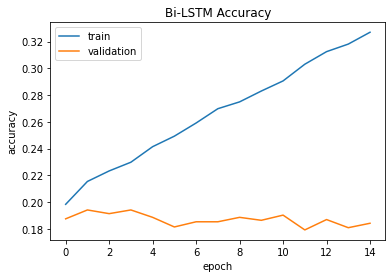

In [104]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Bi-LSTM Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

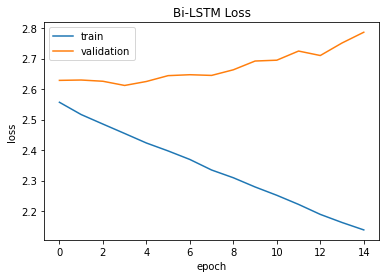

In [105]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Bi-LSTM Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [109]:
y_hat = model.predict(X_test)

In [118]:
f1_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)), average='weighted')

0.17501132155759921

In [233]:
def tokenizer(text): 
    return text.split()

In [234]:
# Spliting test and test set
from sklearn.model_selection import train_test_split
X = twemoji['text'] 
y = twemoji['target'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

## GridSearch

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
def print_scores(model):
    print('Best parameter set: %s ' % model.best_params_)
    print('CV Accuracy: %.3f' % model.best_score_)
    clf = model.best_estimator_
    print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

In [39]:
tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None)

In [40]:
lr_param_grid = [{'vect__ngram_range': [(1, 2),],
               'vect__stop_words' : [None],
               'vect__tokenizer' : [tokenizer], 
               'clf__penalty': ['l2'],
               'clf__C': [1.0,],
              }, 
              {
                'vect__ngram_range' : [(1, 1)], 
                'vect__stop_words' : [None],
                'vect__tokenizer' : [tokenizer,], 
                'vect__use_idf' : [False],
                'vect__norm' : [None],
                'clf__penalty' : ['l2'],
                'clf__C': [1.0,],
              }
             ] 

In [41]:
svm_param_grid = [{'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
                   'vect__stop_words' : [stop, None],
                   'vect__tokenizer' : [tokenizer],
                   'clf__kernel': ['rbf'],
                   'clf__gamma': [1e-3, 1e-4],
                   'clf__C': [1, 10, 100, 1000],
                  },
                  {
                    'vect__ngram_range' : [(1, 1)], 
                    'vect__stop_words' : [stop, None],
                    'vect__tokenizer' : [tokenizer], 
                    'vect__use_idf' : [False],
                    'vect__norm' : [None],
                    'clf__kernel': ['rbf'],
                    'clf__gamma': [1e-3, 1e-4],
                    'clf__C': [1, 10, 100, 1000], 
                   }
]

In [42]:
multiNB_param_grid = [
    {
        'vect__ngram_range': [(1, 1)],
        'vect__stop_words' : [stop, None],
        'vect__tokenizer' : [tokenizer, tokenizer_porter],
    },
    {
        'vect__ngram_range' : [(1, 1), (1, 2), (1, 3)], 
        'vect__stop_words' : [stop, None],
        'vect__tokenizer' : [tokenizer, tokenizer_porter], 
        'vect__use_idf' : [False],
        'vect__norm' : [None], 
    }
    
]

In [43]:
lr_tfidf = Pipeline([('vect', tfidf), ('clf', LogisticRegression(random_state=0))])
svm_tfidf = Pipeline([('vect', tfidf), ('clf', SVC(random_state=0))])
multiNB_tfidf = Pipeline([('vect', tfidf), ('clf', MultinomialNB())])

In [44]:
gs_lr_tfidf = GridSearchCV(lr_tfidf, lr_param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=1)
gs_svm_tfidf = GridSearchCV(svm_tfidf, svm_param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
gs_multiNB_tfidf = GridSearchCV(multiNB_tfidf, multiNB_param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

In [64]:
gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=False,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [65]:
print_scores(gs_lr_tfidf)

Best parameter set: {'clf__C': 1.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 2), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x1631f6f80>} 
CV Accuracy: 0.337
Test Accuracy: 0.345


In [7]:
mappings.iloc[1381]['ucode']

'😂'

## Hashing Vectorizer

In [235]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier

In [236]:
vect = HashingVectorizer(decode_error='ignore', n_features=2**21, preprocessor=None, tokenizer=tokenizer)

In [237]:
# using logistic regression
sgdc_clf = SGDClassifier(loss='log', random_state=0, max_iter=1)

In [238]:
sgdc_clf.fit(vect.transform(X_train), y_train)

SGDClassifier(loss='log', max_iter=1, random_state=0)

In [239]:
# Accuracy
sgdc_clf.score(vect.transform(X_test), y_test)

0.15272244355909695

In [240]:
y_preds = sgdc_clf.predict(vect.transform(X_test))

In [241]:
from sklearn.metrics import f1_score

In [242]:
# F1 Score
f1_score(y_test, y_preds, average='weighted')

0.13773174078428924

##  GloVe

In [167]:
from sklearn.preprocessing import scale

In [168]:
embeddings_path = os.path.join('src', 'embeddings', 'glove.twitter.27B.25d.txt')

In [169]:
def get_w2v_general(tweet, size, vectors, aggregation='mean'):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tweet.split():
        try:
            vec += vectors[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if aggregation == 'mean':
        if count != 0:
            vec /= count
        return vec
    elif aggregation == 'sum':
        return vec

In [170]:
import gensim.downloader as api

glove_twitter = api.load("glove-twitter-200")

In [171]:
X_train_glove_sum = scale(np.concatenate([get_w2v_general(z, 200, glove_twitter, 'sum') for z in X_train]))
X_test_glove_sum = scale(np.concatenate([get_w2v_general(z, 200, glove_twitter, 'sum') for z in X_test]))

In [172]:
sgdc_clf_glove = SVC(random_state=0)

In [173]:
sgdc_clf_glove.fit(X_train_glove_sum, y_train)

SVC(random_state=0)

In [174]:
y_preds = sgdc_clf_glove.predict(X_test_glove_sum)

In [175]:
f1_score(y_test, y_preds, average='weighted')

0.15017741589855627

In [176]:
sgdc_clf_glove.score(X_test_glove_sum, y_test)

0.16301460823373173

In [189]:
sgdc_clf_glove.predict(get_w2v_general('No! You are wrong!', 200, glove_twitter, 'mean'))

array([830])

In [190]:
mappings.iloc[830]['ucode']

'👀'

## LSTM-GloVe

In [ ]:
MAX_SEQUENCE_LENGTH = 200

In [ ]:
sequence_input = Input(shape=MAX_SEQUENCE_LENGTH, dtype='int32')
embedding_layer = Embedding(len())